In [208]:
import numpy as np
import pandas as pd
import xgboost as xgb
import sklearn
import collections

In [209]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [210]:
#Read data
wine_df = pd.read_csv("winequalityN.csv")

In [211]:
#Drop missing values
wine_df = wine_df.dropna()

In [212]:
# Drop target features
features = wine_df.drop(columns=["type","quality"]).columns

In [213]:
#Get only non target features
x = wine_df.loc[:, features]

In [214]:
#Scale data
scale = StandardScaler()
wine_scaled = pd.DataFrame(scale.fit_transform(x), index=x.index)

# Visualization

In [215]:
import plotly.express as px

In [216]:
counter = collections.Counter(wine_df["type"])

In [217]:
#Count of each quality
counter_quality = collections.Counter(wine_df["quality"])
fig = px.bar(wine_df, x=wine_df['quality'].unique(), y=list(counter_quality.values()),
              color=list(counter_quality.values()),
             labels={'pop':'population of Canada'}, height=400)
fig.show()

# Models and training

In [218]:
#Hyperparrameter space for XGBOOST
params = {
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5,6,8],
        'n_estimators':[100, 150, 200, 250,300],
        'learning_rate':np.linspace(0.001, 1, 20)
        }

In [219]:
X_train, X_test, y_train, y_test = train_test_split( np.asmatrix(wine_scaled), wine_df["quality"].values, test_size=0.33, random_state=42)

In [220]:
#Convert to matrix and get target variables
X = np.asmatrix(wine_scaled)
Y = wine_df["quality"].values

In [221]:
#Default XGBoost
xgbm = xgb.XGBClassifier(objective="multi:softmax", num_class=7)

In [93]:
#Scorer for Grid Search
scorer = sklearn.metrics.make_scorer(sklearn.metrics.f1_score, average = 'weighted')

In [29]:
grid = GridSearchCV(estimator=xgbm, param_grid=params, n_jobs=4, scoring='accuracy', verbose=1 )

In [30]:
grid.fit(X, Y)

Fitting 5 folds for each of 1125 candidates, totalling 5625 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   36.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 10.5min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed: 18.9min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed: 29.6min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed: 44.0min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed: 62.2min
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed: 83.3min
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed: 105.5min
[Parallel(n_jobs=4)]: Done 4992 tasks      | elapsed: 126.1min
[Parallel(n_jobs=4)]: Done 5625 out of 5625 | elapsed: 141.5min finished


GridSearchCV(cv=<generator object _BaseKFold.split at 0x0000022731F8BEC8>,
             error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.05, max_delta_step=None,
                                     max_depth=6, min_child_weight=N...
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=None),
             iid='deprecated', n_jobs=4,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
            

In [52]:
grid.best_params_

{'colsample_bytree': 0.8,
 'gamma': 0.5,
 'max_depth': 8,
 'n_estimators': 300,
 'subsample': 0.8}

In [222]:
xgb_best = xgb.XGBClassifier(colsample_bytree=0.8, 
                             gamma=0.5, 
                             learning_rate=0.05,
                             max_depth=8,
                             n_estimators=300,
                             n_jobs=0,
                             num_class=7, 
                             objective='multi:softprob',
                             subsample=0.8)

In [223]:
xgb_best = xgb_best.fit(X_train,y_train)

In [224]:
xgb_best_prediction = xgb_best.predict(X_test)

In [225]:
print(classification_report(y_test, xgb_best_prediction, target_names=[str (i) for i in wine_df["quality"].unique()].sort()))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         8
           4       0.37      0.10      0.16        67
           5       0.71      0.69      0.70       721
           6       0.63      0.76      0.69       912
           7       0.66      0.51      0.57       356
           8       0.87      0.29      0.44        68
           9       0.00      0.00      0.00         1

    accuracy                           0.66      2133
   macro avg       0.46      0.34      0.37      2133
weighted avg       0.66      0.66      0.65      2133



C:\Users\grigor.vardanyan\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [226]:
#We see that we can not predict well  some of the classes reason is imbalanced data

# Transforming to low, middle, high

In [227]:
#Lets transform our data between 3 groups and see what will happen
def transform_target(x):
    if x < 5:
        return "low"
    elif x < 7:
        return "middle"
    else:
        return "high"

In [228]:
#transformed target
quality_transformed = wine_df["quality"].apply(lambda x: transform_target(x))

In [229]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split( np.asmatrix(wine_scaled), quality_transformed, test_size=0.33, random_state=42)

# Greed Saerch on XGBoost

In [230]:
#Default model
xgb_tras = xgb.XGBClassifier(objective="multi:softmax", num_class=3)

In [107]:
grid = GridSearchCV(estimator=xgb_tras, param_grid=params, n_jobs=8, scoring=scorer,cv=5, verbose=3 )

In [108]:
grid.fit(X_train,y_train)

Fitting 5 folds for each of 22500 candidates, totalling 112500 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    3.8s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   19.5s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  1.0min
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  3.4min
[Parallel(n_jobs=8)]: Done 1136 tasks      | elapsed:  4.9min
[Parallel(n_jobs=8)]: Done 1552 tasks      | elapsed:  6.6min
[Parallel(n_jobs=8)]: Done 2032 tasks      | elapsed:  8.6min
[Parallel(n_jobs=8)]: Done 2576 tasks      | elapsed: 10.9min
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed: 13.4min
[Parallel(n_jobs=8)]: Done 3856 tasks      | elapsed: 16.2min
[Parallel(n_jobs=8)]: Done 4592 tasks      | elapsed: 19.3min
[Parallel(n_jobs=8)]: Done 5392 tasks      | elapsed: 22.8min
[Parallel(n_jobs=8)]: Done 6256 tasks      | elapsed: 26.7min
[Parallel(n_jobs=8)]: Done 7184 tasks      | elapsed: 31.0min


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estim...
       0.26389474, 0.31647368, 0.36905263, 0.42163158, 0.47421053,
       0.52678947, 0.57936842, 0.63194737, 0.68452632, 0.73710526,
       0.78968421, 0.84226316, 0.89484211, 0.94742105, 1.        ]),
                         'max_depth': [3, 4, 5, 6, 8],
                         

In [109]:
grid.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1061578947368421, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.6,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [231]:
#Our best XGBoost model
xgb_trans_best = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1061578947368421, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.6,
              tree_method='exact', validate_parameters=1, verbosity=None).fit(X_train, y_train)

In [232]:
xgb_tras_pred = xgb_trans_best.predict(X_test)

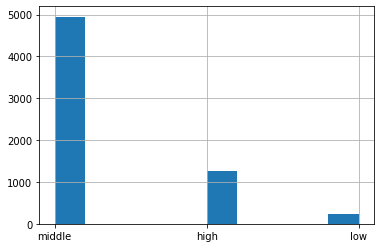

In [233]:
#Histogram of cass frequancy
quality_transformed.hist()

In [234]:
print(classification_report(y_test, xgb_tras_pred, target_names=quality_transformed.unique()))

              precision    recall  f1-score   support

      middle       0.75      0.56      0.64       425
        high       0.29      0.07      0.11        75
         low       0.86      0.95      0.90      1633

    accuracy                           0.84      2133
   macro avg       0.63      0.52      0.55      2133
weighted avg       0.82      0.84      0.82      2133



# Random Forest

In [178]:
rf = RandomForestClassifier()

In [179]:
params_rf = {
        'max_depth': [3, 4, 5, 6, 8],
        'n_estimators':[100, 150, 200, 250,300]
        }

In [34]:
grid = GridSearchCV(estimator=rf, param_grid=params_rf, n_jobs=8, cv=5, verbose=3 )

In [35]:
grid.fit(X_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done 125 out of 125 | elapsed:   28.8s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [36]:
grid.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [235]:
#Best random forest model
rf_best = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False).fit(X_train,y_train)

In [236]:
rf_best_pred = rf_best.predict(X_test)

In [237]:
print(classification_report(y_test, rf_best_pred, target_names=quality_transformed.unique()))

              precision    recall  f1-score   support

      middle       0.74      0.39      0.51       425
        high       0.00      0.00      0.00        75
         low       0.83      0.96      0.89      1633

    accuracy                           0.82      2133
   macro avg       0.52      0.45      0.47      2133
weighted avg       0.78      0.82      0.78      2133



# Balanced data

In [238]:
# Lets make balanced data and see what we will happen

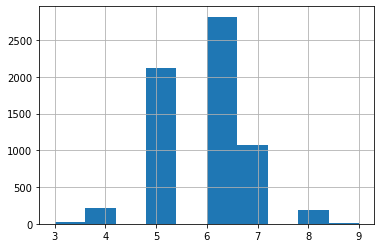

In [239]:
winde_quality = wine_df["quality"].hist()

In [28]:
#Get stats same as In visualization part
counter = collections.Counter(wine_df["quality"])
counter_dict = dict(counter)
keys = list(counter_dict.keys())
keys.sort()

for key in keys:
    print( "Key - {} - Values  - {}".format(key, counter_dict[key]))

Key - 3 - Values  - 30
Key - 4 - Values  - 214
Key - 5 - Values  - 2128
Key - 6 - Values  - 2820
Key - 7 - Values  - 1074
Key - 8 - Values  - 192
Key - 9 - Values  - 5


In [186]:
# Lets shrink  5, 6 and 7 to have 214 elements which is equal to 4 quality.and we will keep 3, 4, 8 and 9 

In [240]:
wine_temp = wine_df.loc[wine_df['quality'].isin([5, 6,7])]

In [241]:
wine_groups = wine_temp.groupby("quality")

In [242]:
balanced_df = wine_df.loc[wine_df['quality'].isin([3, 4, 8, 9])]
for name, group in wine_groups:
    balanced_df = balanced_df.append(group.sample(214))

In [243]:
balanced_df

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
20,white,6.2,0.660,0.48,1.2,0.029,29.0,75.0,0.98920,3.33,0.39,12.8,8
22,white,6.8,0.260,0.42,1.7,0.049,41.0,122.0,0.99300,3.47,0.48,10.5,8
46,white,6.2,0.450,0.26,4.4,0.063,63.0,206.0,0.99400,3.27,0.52,9.8,4
68,white,6.7,0.230,0.31,2.1,0.046,30.0,96.0,0.99260,3.33,0.64,10.7,8
74,white,6.7,0.230,0.31,2.1,0.046,30.0,96.0,0.99260,3.33,0.64,10.7,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1287,white,8.3,0.210,0.40,1.6,0.032,35.0,110.0,0.99070,3.02,0.60,12.9,7
1099,white,5.8,0.290,0.21,2.6,0.025,12.0,120.0,0.98940,3.39,0.79,14.0,7
858,white,6.7,0.220,0.39,10.2,0.038,60.0,149.0,0.99725,3.17,0.54,10.0,7
5244,red,6.6,0.815,0.02,2.7,0.072,17.0,34.0,0.99550,3.58,0.89,12.3,7


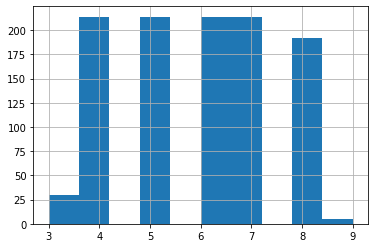

In [245]:
#Our reduced data
balanced_df.quality.hist()

In [246]:
#Here as we see we ruduced data wich has more frequancy than others

In [247]:
encoder = LabelEncoder()
y = encoder.fit_transform(balanced_df.quality.values)

In [248]:
x = balanced_df.loc[:,features]

In [249]:
scale = StandardScaler()
wine_scaled = pd.DataFrame(scale.fit_transform(x), index=x.index)

In [250]:
X_train, X_test, y_train, y_test = train_test_split( np.asmatrix(wine_scaled), y, test_size=0.33, random_state=42)

In [251]:
labels = [str(i) for  i in wine_df.quality.unique()]
labels.sort()

In [252]:
xgb_balanced_def = xgb.XGBClassifier(objective="multi:softmax", num_class=7)

In [253]:
params_balanced = {
        'gamma': [0.5, 1, 1.5, 2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 6, 8],
        'n_estimators':[ 200, 250,300],
        'learning_rate':np.linspace(0.001, 1, 10)
        }

In [98]:
grid = GridSearchCV(estimator=xgb_balanced_def, param_grid=params_balanced, n_jobs=8, scoring=scorer, verbose=1 )

In [99]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 5400 candidates, totalling 27000 fits


C:\Users\grigor.vardanyan\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   12.7s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   54.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  3.7min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:  5.7min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:  8.1min
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed: 10.8min
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed: 14.2min
[Parallel(n_jobs=8)]: Done 4034 tasks      | elapsed: 17.9min
[Parallel(n_jobs=8)]: Done 4984 tasks      | elapsed: 21.5min
[Parallel(n_jobs=8)]: Done 6034 tasks      | elapsed: 25.7min
[Parallel(n_

GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_es...
             iid='deprecated', n_jobs=8,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0.5, 1, 1.5, 2],
                         'learning_rate': array([0.001, 0.112, 0.223, 0.334, 0.445, 0.556, 0.667, 0.778, 0.889,
       1.   ]),


In [101]:
grid.best_params_

{'colsample_bytree': 0.6,
 'gamma': 1.5,
 'learning_rate': 0.445,
 'max_depth': 4,
 'n_estimators': 300,
 'subsample': 1.0}

In [254]:
xgb_balanced_best = xgb.XGBClassifier(objective="multi:softmax", num_class=7,
                                     colsample_bytree=0.6,
                                     gamma=1.5,
                                     learning_rate = 0.445,
                                    max_depth=4,
                                    n_estimators=300,
                                    subsample=1).fit(X_train,y_train)

In [255]:
xgb_bal_best_pred = xgb_balanced_best.predict(X_test)

In [256]:
print(classification_report(y_test, xgb_bal_best_pred, target_names=labels))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00        11
           4       0.60      0.54      0.57        79
           5       0.52      0.45      0.49        77
           6       0.35      0.41      0.37        64
           7       0.38      0.51      0.44        61
           8       0.52      0.52      0.52        64
           9       0.00      0.00      0.00         2

    accuracy                           0.47       358
   macro avg       0.34      0.35      0.34       358
weighted avg       0.46      0.47      0.46       358



C:\Users\grigor.vardanyan\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [257]:
# As we see th treick to balance data did not helped us